# Vector Space Semantics and Word Embeddings

Word embeddings are a powerful concept in natural language processing (NLP) that involve representing words as vectors in a continuous vector space. Word embeddings capture semantic information about words. This means that words with similar meanings are represented by vectors that are close to each other in the vector space. 

In this assignment, we'll look at more traditional, *sparse* representations of words (i.e. where words are represented by vectors of size |V| with the word count corresponding to the word's index in the vocabulary), and then play with more advanced, *dense* representations of words, learned via neural network.

## Part 1: Sparse Vector Representations

We'll implement TF-IDF and PPMI, two methods to represent words and documents in a sparse matrix. We have provided a *term-document matrix* for the BLT corpus, treating each review as a document. The documents (columns) are represented via word count (rows). The columns of the matrix represent each review, and the rows represent every word in the vocabulary. One cell of the matrix gives the term frequency for that document.

Because most words do not appear in most reviews, the matrix will be mostly 0s. This is why we call it sparse.

In [2]:
# Imports
import pandas as pd
import numpy as np
from typing import Tuple

In [3]:
# Get the term x doc matrix of the BLT corpus
# Note: the matrix does not include reviews that were flagged for rejection in the corpus
termxdoc = pd.read_csv('blt_termxdoc.csv', index_col=0)

In [4]:
termxdoc # checking it out...

,ID-0205,ID-0283,ID-0452,ID-0187,ID-0593,ID-1570,ID-0975,ID-0819,ID-0444,ID-0260,...,ID-0143,ID-1431,ID-1286,ID-1284,ID-0354,ID-0046,ID-0470,ID-0706,ID-0338,ID-0675
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0ghz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zooming,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zuckerberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Our term x doc matrix provides a representation of the BLT corpus in terms of the 
# frequency of each term in each document. The rows represent the terms and the columns 
# represent the documents. The values in the matrix represent the frequency of each term 
# in each document.
#
# The matrix is sparse, as most terms do not appear in most documents.
# For example, let's find the frequency of the term 'grill' in each document:
termxdoc.loc['grill']

ID-0205    3
ID-0283    0
ID-0452    0
ID-0187    0
ID-0593    0
          ..
ID-0046    0
ID-0470    0
ID-0706    0
ID-0338    0
ID-0675    0
Name: grill, Length: 1492, dtype: int64

In [58]:
# Summing across axis 1 (columns) gives the term frequencies across the entire corpus
termxdoc.sum(axis=1).sort_values(ascending=False).head(10) # Top 10 terms by frequency; 'the' is the most frequent term

the     9525
and     5091
to      4386
it      3165
was     2840
of      2245
is      2224
in      1963
for     1848
this    1825
dtype: int64

### Implement TF-IDF

Let's implement TF-IDF using the term-document matrix. As a reminder, TF-IDF is a $|V| x N$ matrix in which the weighted value $w_{t,d}$ for word $t$ in document $d$ combines term frequency $\text{tf}_{t,d}$ with the inverse document frequency $\text{idf}$:

$$
w_{t,d} = \text{tf}_{t,d} * \text{idf}_t
$$

We will use logarithmically scaled term frequency:

$$
\text{tf}_{t,d} = \begin{cases}
                     1 +\log\text{count}(t,d) & \text{if count}(t,d) > 0 \\
                     0 & \text{otherwise}
                   \end{cases}
$$

The $\text{idf}$ is defined using the fraction $N/\text{df}_t$, where $N$ is the total number of documents in the collection, and $\text{df}_t$ is the number of documents in which term $t$ occurs. The fewer documents in which a term occurs, the higher this weight. The lowest weight of 1 is assigned to terms that occur in all the documents.

We'll also logarithmically scale the inverse document frequency in our implementation:

$$
\text{idf}_t = \log \frac{N}{\text{df}_t} 
$$

In [60]:
def tfidf(termxdoc: pd.DataFrame) -> pd.DataFrame:
    """This function takes a raw term x doc matrix and returns a term x doc matrix with tfidf values.
    Remember, the rows are the term counts and the columns are the documents."""
    
    # Get the term frequency
    log_counts = np.log(termxdoc)
    log_counts[np.isinf(log_counts)] = 0.0 # log(0) goes to 0
    tfs = 1 + log_counts
    
    # your code here
    N = termxdoc.shape[1]
    df_t = (termxdoc > 0).sum(axis=1)
    idfs = np.log(N / df_t)
    tfidf = tfs.multiply(idfs, axis="index")

    return tfidf

In [61]:
blt_tfidf = tfidf(termxdoc)

In [62]:
blt_tfidf.loc['grill'] # Check to see how the tfidf values for the term 'grill' have changed

ID-0205    10.725269
ID-0283     5.110648
ID-0452     5.110648
ID-0187     5.110648
ID-0593     5.110648
             ...    
ID-0046     5.110648
ID-0470     5.110648
ID-0706     5.110648
ID-0338     5.110648
ID-0675     5.110648
Name: grill, Length: 1492, dtype: float64

In [63]:
assert np.isclose(blt_tfidf.loc['grill'][0], 10.725269122772522)
print('TF-IDF implementation seems to be working!')

TF-IDF implementation seems to be working!


### Implement PPMI

In NLP, the pointwise mutual information between a target word $i$ and a context word $j$ is defined as the observations of $i$ and $j$ co-occurring, divided by our expectations of $i$ and $j$ occurring assuming they each occurred independently:

$$
PMI(i, j) = \log\frac{\text{observed}(i, j)}{\text{expected}(i, j)} = \log\frac{P(i, j)}{P(i)P(j)}
$$

Given a word co-occurrence matrix $W$ where $w_{i,j}$ gives the number of times word $w_i$ occurs with context $w_j$, we have

$$
\text{observed}(i, j) = W_{i,j}
$$

and our $\text{expected}(i,j)$ value can be defined as:

$$
\text{expected}(i,j) = \frac{\text{rowsum}(i)\cdot\text{colsum}(j)}{\text{sum}(W)}
$$

Finally, we define *positive* PMI (PPMI) as follows:

$$
PPMI_{ij} = \max(\log\frac{\text{observed}(i,j)}{\text{expected}(i,j)},0)
$$


PPMI fixes the problem of taking the log of 0-count cells.

TF-IDF measured term-document frequencies, but PPMI measures term-term frequencies. So, we've provided a term-term matrix for the BLT corpus. The counts are simple: for the matrix $W_{i,j}$, a context word $w_j$ appears in the same review as target word $w_i$ a total of $w_{i,j}$ times. To keep things relatively faster, we've truncated the matrix to the most frequent 3,000 terms (on both axes).

In [67]:
# Get the term x term matrix
termxterm = pd.read_csv('blt_termxterm.csv', index_col=0)

In [65]:
termxterm

,00,10,100,1000,1080p,12,15,150,17,20,...,yet,york,you,young,your,yourself,youtube,zio,zoo,zune
00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,11.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
10,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,1.0,0.0,35.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1080p,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yourself,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,34.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0
youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
zio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
zoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
termxterm.loc['grill'].sort_values(ascending=False)

the         135.0
and          70.0
to           46.0
was          39.0
it           31.0
            ...  
full          0.0
fully         0.0
fun           0.0
function      0.0
zune          0.0
Name: grill, Length: 3000, dtype: float64

In [72]:
def ppmi(termxterm: pd.DataFrame) -> pd.DataFrame:
    """This function takes a raw term x term matrix and returns a term x term matrix with PPMI values."""
    context_word_sums = termxterm.sum(axis=0) # sum context words (column sum)
    sum_W = context_word_sums.sum() # total words in corpus
    target_word_sums = termxterm.sum(axis=1) # sum target words (row sum)

    # your code here
    # 1. Calculate P(t, c)
    # P(t, c) = C(t, c) / sum_W
    P_tc = termxterm / sum_W 
    
    # 2. Calculate P(t) * P(c)
    # P(t) = target_word_sums / sum_W
    # P(c) = context_word_sums / sum_W
    # P(t) * P(c) = (target_word_sums * context_word_sums) / sum_W^2
    
    # Use pandas outer product to get the matrix of P(t) * P(c) denominators (numerator is C(t,c))
    # Outer product: target_word_sums (Series) x context_word_sums (Series)
    P_t_Pc = np.outer(target_word_sums, context_word_sums) / (sum_W ** 2)
    P_t_Pc = pd.DataFrame(P_t_Pc, index=termxterm.index, columns=termxterm.columns) # Convert back to DataFrame
    
    # 3. Calculate Pointwise Mutual Information (PMI)
    # PMI(t, c) = log2 ( P(t, c) / (P(t) * P(c)) )
    
    # Replace zeros in P_t_Pc with a tiny number to avoid division by zero in the log calculation.
    # P(t)P(c) = 0 means either P(t)=0 or P(c)=0. If P(t)=0, then C(t,c)=0, and P(t,c)=0.
    # The standard approach is to use a masked array or a very small epsilon.
    # Here, we'll check if the numerator C(t,c) is 0. If it is, the resulting PMI is 0 * log(0/tiny) which is -inf.
    # However, since we'll apply max(0, PMI) later, any large negative number is fine.
    # Let's use np.divide and set where P_t_Pc is 0 to a small epsilon.
    P_t_Pc_safe = P_t_Pc.replace(0, 1e-12) # Use a very small positive number
    
    # Calculate the ratio P(t, c) / (P(t) * P(c))
    ratio = P_tc / P_t_Pc_safe
    
    # Calculate log2 of the ratio to get PMI
    pmi = np.log2(ratio)
    
    # 4. Calculate Positive Pointwise Mutual Information (PPMI)
    # PPMI(t, c) = max(0, PMI(t, c))
    ppmi = pmi.clip(lower=0)    
    return ppmi

In [69]:
blt_ppmi = ppmi(termxterm)

In [70]:
blt_ppmi.loc['grill'].sort_values(ascending=False) # Check to see how the PPMI values for the term 'grill' have changed

george     7.501491
foreman    7.369970
steaks     6.976364
screw      6.913002
forty      6.364565
             ...   
friday     0.000000
fridge     0.000000
friend     0.000000
front      0.000000
zune       0.000000
Name: grill, Length: 3000, dtype: float64

In [71]:
assert np.isclose(blt_ppmi.loc['grill'][0], 0.0)
print('PPMI implementation seems to be working!')

PPMI implementation seems to be working!


### Implement nearest neighbors

Now that we have a couple of different vector spaces for the BLT corpus, let's play around with them.

Implement a `nearest_neighbors` function that returns the `k` nearest neighbors for a term, given a vector space (matrix). Use cosine similarity for the distance function:

$$
\text{cosine distance}(u,v) = 1 - \frac{u \cdot v}{||u||_2 \cdot ||v||_2}
$$

In [15]:
def nearest_neighbors(term: str, matrix: pd.DataFrame, k: int) -> pd.DataFrame:
    """This function takes a term, a term x doc matrix, and a number of neighbors k, 
    and returns the k nearest neighbors of the term using cosine distance."""
    # your code here
    # Check if the term is in the matrix index
    if term not in matrix.index:
        print(f"Error: Term '{term}' not found in the matrix index.")
        return pd.DataFrame()
        
    # --- 1. Isolate Target Vector and Calculate its Norm ---
    
    # Extract the vector for the target term
    target_vector = matrix.loc[term].values
    
    # Calculate the L2 norm (magnitude) of the target vector: ||target_vector||
    target_norm = np.linalg.norm(target_vector)
    
    # Check for zero vector, which would cause division by zero
    if target_norm == 0:
        print(f"Error: Target term '{term}' has a zero vector. Cannot calculate cosine similarity.")
        return pd.DataFrame()
        
    # --- 2. Calculate Numerator (Dot Product) and Denominator (Norm Product) ---

    # Calculate all pairwise dot products (Numerator: target_vector . matrix_rows)
    # The dot product is: (1 x N) @ (N x D) -> (1 x D) but the term x doc matrix is D x N (Terms x Docs).
    # Since we are comparing term vectors (rows), we need to compute dot product of the target row
    # with every other row (term).
    # Dot product: target_vector (1 x M) @ matrix_rows (M x D). We want (1 x M) @ (M x D) -> (1 x D)
    # No, we want the dot product of target_vector with EACH ROW of the matrix.
    # We can use matrix @ target_vector if we were comparing features, but we compare rows (terms).
    
    # A cleaner way is element-wise multiplication and summation across the features (columns)
    dot_products = (matrix.values * target_vector).sum(axis=1)

    # Calculate the Norms of all term vectors (Denominator part 1: ||v||)
    # np.linalg.norm calculates the L2 norm along the specified axis (axis=1 for rows)
    all_norms = np.linalg.norm(matrix.values, axis=1)

    # Calculate the product of norms (Denominator: ||target_vector|| * ||v||)
    # all_norms contains ||v|| for every term v
    norm_products = target_norm * all_norms
    
    # --- 3. Calculate Cosine Similarity ---
    
    # To prevent division by zero, set denominator where norm_products is zero to 1.
    # Since dot_products will also be zero in those cases, the similarity will correctly be 0.
    # Use np.divide to handle this safely.
    
    # Use np.divide with a mask to avoid RuntimeWarning for division by zero
    similarities = np.divide(dot_products, norm_products, 
                             out=np.zeros_like(dot_products, dtype=float), 
                             where=norm_products != 0)

    # Convert the similarities array to a Series indexed by the term names
    similarity_series = pd.Series(similarities, index=matrix.index)
    
    # --- 4. Select and Format Neighbors ---
    
    # Remove the target term itself (similarity should be 1.0)
    similarity_series = similarity_series.drop(term, errors='ignore')
    
    # Sort the terms by similarity in descending order
    sorted_neighbors = similarity_series.sort_values(ascending=False)
    
    # Select the top k neighbors
    neighbors = sorted_neighbors.head(k)    
    return neighbors

In [108]:
sample_matrix = pd.DataFrame(
    [[1.0,  2.0],
    [2.0, 1.0],
    [11.0, 20.0],
    [18.0, 1.0]],
    index=['a', 'b', 'c', 'd'],
    columns=['x', 'y'])
sample_matrix 

,x,y
a,1.0,2.0
b,2.0,1.0
c,11.0,20.0
d,18.0,1.0


In [115]:
neighbors_to_check = nearest_neighbors('a', sample_matrix, 1).index
assert 'c' in neighbors_to_check
neighbors_to_check = nearest_neighbors('a', sample_matrix, 2).index
assert 'b' in neighbors_to_check
print('Nearest neighbors implementation is working!')

Nearest neighbors implementation is working!


In [81]:
nearest_neighbors('grill', blt_tfidf, 10) # Get the 10 nearest neighbors of the term 'grill' using the tfidf matrix

,Neighbor,Cosine Similarity
0,foreman,0.999840
1,george,0.999840
2,steaks,0.999785
3,college,0.999624
4,roommates,0.999597
5,pleased,0.999437
6,due,0.999437
7,matter,0.999437
8,returning,0.999437
9,rates,0.999437


In [103]:
neighbors_to_check = nearest_neighbors('grill', blt_tfidf, 10).index
nns_tfidf = ['george', 'foreman', 'steaks', 'college', 'roommates', 'coming', 'intrigued', 'conversations', 'quietness', 'quest']
for nn in nns_tfidf:
    assert nn in neighbors_to_check

foreman      0.999840
george       0.999840
steaks       0.999785
college      0.999624
roommates    0.999597
pleased      0.999437
due          0.999437
matter       0.999437
returning    0.999437
rates        0.999437
dtype: float64


AssertionError: 

In [100]:
nearest_neighbors('grill', blt_ppmi, 10) # Get the 10 nearest neighbors of the term 'grill' using the PPMI matrix

george       0.721943
foreman      0.708017
forty        0.569300
steaks       0.546262
screw        0.532580
apartment    0.453470
stone        0.450156
plants       0.448995
roommate     0.435870
steak        0.431897
dtype: float64

In [99]:
neighbors_to_check = nearest_neighbors('grill', blt_ppmi, 10).index
nns_ppmi = ['george', 'foreman', 'forty', 'steaks', 'screw', 'apartment', 'stone', 'plants', 'roommate', 'steak']
for nn in nns_ppmi:
    assert nn in neighbors_to_check

## Part 2: Dimensionality reduction

We can capture latent relations among the words in our vocabulary words by reducing the dimensions of our sparse matrices and getting dense embeddings. We'll explore a technique called Latent Semantic Analysis (LSA) to do this with our term-document matrix.

### Implement LSA

LSA uses SVD (singular value decomposition) to factor a matrix into three matrices:

$$
X_{mxn} = T_{mxr} S_{rxr} V^T_{rxn}
$$

$S$ is diagonal matrix containing what are called the singular values. The entries in $S$ along the diagonal are non-negative values sorted in descending order.

For LSA, for a term-document matrix $X_{mxn}$ in which we have $m$ terms and $n$ documents, we keep only the $k$ highest values in $S$, along with the first $k$ columns of $T$:

$$
LSA(X_{mxn}) = W_{mxk} = T_{mxk} S_{kxk}
$$

We can throw away $V^T_{rxn}$ and we're left with what we call an embedding matrix $W$ with $k$ dimensions.


In our own implementation, we'll keep $S$ as well as $W$ so we can implement vectorization using $S^{-1}$. Feel free to use a library for SVD, e.g. https://numpy.org/doc/2.1/reference/generated/numpy.linalg.svd.html.

In [5]:
def lsa(matrix: pd.DataFrame, k: int):
    """This function takes a term x doc matrix and a number of components k, and returns the W matrix
    from the LSA algorithm."""
    T, S, V_T = np.linalg.svd(matrix, full_matrices=False)
    # your code here
    # 1. Truncate T to k columns (T_k)
    # T_k is the M x k Term-Concept matrix
    T_k = T[:, :k]
    
    # 2. Truncate S to k singular values (S_k)
    # Create the k x k diagonal matrix S_k from the top k singular values
    S_k = np.diag(S[:k])
    
    # 3. Calculate W = T_k @ S_k
    # This matrix (W) provides the term vectors in the k-dimensional space,
    # weighted by the importance of each concept (singular value).
    W_values = T_k @ S_k
    
    # 4. Convert back to a DataFrame with original term index
    W = pd.DataFrame(
        W_values, 
        index=matrix.index, 
        columns=[f'Concept_{i+1}' for i in range(k)]
    )    
    return W

In [6]:
# This may take a few minutes...
blt_lsa_50 = lsa(termxdoc, 50) # Get the LSA matrix with 50 components

In [7]:
# This one will take a while too...
blt_lsa_100 = lsa(termxdoc, 100) # Get the LSA matrix with 100 components

In [11]:
# And this one will take even longer. Hang in there!
blt_lsa_300 = lsa(termxdoc, 300) # Get the LSA matrix with 300 components

In [12]:
blt_lsa_100 # Our term x doc matrix is not so sparse anymore!

,Concept_1,Concept_2,Concept_3,Concept_4,Concept_5,Concept_6,Concept_7,Concept_8,Concept_9,Concept_10,...,Concept_91,Concept_92,Concept_93,Concept_94,Concept_95,Concept_96,Concept_97,Concept_98,Concept_99,Concept_100
00,-0.337729,0.030428,-0.289372,0.099743,0.123989,0.287793,-0.050793,-0.177922,0.081096,-0.107518,...,0.228895,-0.174924,0.048175,-0.040436,-0.037582,0.108785,0.200363,-0.213669,-0.294510,0.040410
000,-0.082310,-0.079840,0.056936,-0.016603,0.050213,0.027256,-0.021573,-0.048401,-0.080795,-0.066724,...,-0.040603,-0.026761,0.030802,-0.157453,-0.014541,0.016961,-0.087543,0.047795,0.073552,-0.039668
00000,-0.026856,-0.001017,-0.002226,0.026351,-0.001152,0.029392,0.006919,0.012724,-0.030282,-0.030569,...,0.028871,0.018505,0.025907,0.037920,0.037831,0.011190,-0.012039,-0.024575,0.001921,0.025191
0ghz,-0.067586,-0.104023,-0.040115,-0.005505,0.022026,-0.026261,-0.003806,0.093873,0.060789,-0.081911,...,-0.026619,0.044841,-0.000736,0.041596,0.009364,0.016540,0.070261,0.037418,-0.022432,-0.052236
10,-1.038601,-0.358881,-0.194196,0.334137,-0.069016,0.073696,0.011153,0.222573,-0.565762,-0.162836,...,0.260699,-0.247159,-0.149162,-0.121461,0.048312,-0.050132,-0.303394,0.005052,-0.226305,-0.245994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,-0.207406,-0.042849,0.035683,-0.045070,-0.080424,0.114591,-0.289061,0.186467,-0.114995,-0.052622,...,0.033580,-0.041077,-0.049015,-0.065160,0.008702,-0.063326,0.075945,-0.016614,-0.051467,-0.013559
zoo,-0.159952,0.025758,-0.094489,-0.026419,-0.005336,0.002858,0.164085,0.012765,0.091644,-0.015043,...,0.034155,0.003312,0.107246,0.063340,-0.005610,0.135988,-0.060506,-0.066127,-0.067514,-0.066032
zooming,-0.014362,-0.000993,0.019226,-0.016662,0.006541,0.003561,0.001025,0.010071,-0.004775,0.003967,...,-0.059341,0.006510,-0.043915,-0.051506,0.009972,-0.011751,-0.015767,0.029369,0.016404,-0.012646
zuckerberg,-0.027419,-0.031051,0.003843,-0.076670,0.044549,0.056706,-0.100578,-0.080458,-0.021549,0.024261,...,0.009003,0.068366,-0.004986,0.026846,0.087069,-0.006020,0.013672,-0.008127,-0.078812,-0.052237


In [13]:
blt_lsa_100.loc['grill'] # The 'grill' term vector in the LSA matrix...

Concept_1     -0.410814
Concept_2      0.010690
Concept_3      0.145997
Concept_4     -0.090845
Concept_5     -0.225709
                 ...   
Concept_96     0.230076
Concept_97    -0.017198
Concept_98    -0.076032
Concept_99     0.063146
Concept_100    0.366603
Name: grill, Length: 100, dtype: float64

In [16]:
# Let's look at the nearest neighbors of the term 'grill' in our LSA matrices
nearest_neighbors('grill', blt_lsa_50, 10)

george             0.808201
foreman            0.790962
boxing             0.745916
stupendous         0.745916
slapped            0.745916
instantaneously    0.745916
consummate         0.745916
champ              0.730448
unto               0.709147
steaks             0.679036
dtype: float64

In [17]:
neighbors_to_check = nearest_neighbors('grill', blt_lsa_50, 10).index
nns_lsa50 = ['george', 'foreman', 'boxing', 'consummate', 'instantaneously', 'slapped', 'stupendous', 'champ', 'unto', 'steaks']
for nn in nns_lsa50:
    assert nn in neighbors_to_check
print('LSA (n=50)) implementation seems to be working!')

LSA (n=50)) implementation seems to be working!


In [18]:
nearest_neighbors('grill', blt_lsa_100, 10)

george             0.804667
foreman            0.790628
boxing             0.739646
consummate         0.739646
instantaneously    0.739646
stupendous         0.739646
slapped            0.739646
unto               0.699801
champ              0.687568
steaks             0.670464
dtype: float64

In [19]:
neighbors_to_check = nearest_neighbors('grill', blt_lsa_100, 10).index
nns_lsa100 = ['george', 'foreman', 'boxing', 'consummate', 'instantaneously', 'slapped', 'stupendous', 'champ', 'unto', 'steaks']
for nn in nns_lsa100:
    assert nn in neighbors_to_check
print('LSA (n=100)) implementation seems to be working!')

LSA (n=100)) implementation seems to be working!


In [20]:
nearest_neighbors('grill', blt_lsa_300, 10)

george             0.894890
foreman            0.887737
consummate         0.839541
instantaneously    0.839541
stupendous         0.839541
boxing             0.839541
slapped            0.839541
scare              0.795989
unto               0.795026
champ              0.794933
dtype: float64

In [21]:
neighbors_to_check = nearest_neighbors('grill', blt_lsa_300, 10).index
nns_lsa300 = ['george', 'foreman', 'instantaneously', 'slapped', 'consummate', 'boxing', 'stupendous', 'scare', 'unto', 'champ']
for nn in nns_lsa300:
    assert nn in neighbors_to_check
print('LSA (n=300)) implementation seems to be working!')

LSA (n=300)) implementation seems to be working!


## Part 3: Sentiment Analysis

Let's see how we do on sentiment analysis on the BLT corpus using our LSA matrices. We can think of our LSA matrices as 50-, 100-, and 300-dimension word embeddings. Similar to our ngram language modeling approach to sentiment analysis, we can try to classify the sentiment of unseen reviews by finding reviews that are similar to known positive reviews or known negative reviews.

We'll represent our positive and negative reviews using our LSA word embeddings, and then, given an unseen review, we'll take a vote: compare it across all of the reviews, and classify it as positive if the majority of the similar reviews are positive, and classify it as negative if the majority of the similar reviews are negative.

### Representing reviews with LSA embeddings

Let's create a function `review2vec` that takes the text of a review and a matrix of embeddings, and turns it into a vector based on those embeddings.

We will tokenize the review and then find word embeddings for every word in the review. Then, we'll take the centroid of all the embeddings in the review: that is to say, we'll simply average all the word embeddings.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

def review2vec(review: str, matrix: pd.DataFrame) -> np.array:
    """This function takes a review and a matrix of word embeddings, 
    and returns the vector representation of the review.
    The review vector is the average of the vectors of the 
    words in the review that are in the matrix."""
    # Get words in review
    # We're tokenizing the review using the same tokenizer used to build the term x doc matrix
    # This avoids out-of-vocabulary words
    words = vectorizer.build_tokenizer()(review)

    # Initialize review vector as zeros
    review_vector = np.zeros(matrix.shape[1])

    # your code here
    
    # Counter for words found in the matrix
    found_count = 0 

    # Loop through all words in the review
    for word in words:
        # Check if the word exists as an index (term) in the embedding matrix
        if word in matrix.index:
            # Add the word's vector (the corresponding row) to the accumulating vector
            review_vector += matrix.loc[word].values
            found_count += 1

    # Average the vectors if at least one word was found
    if found_count > 0:
        review_vector /= found_count    

    return review_vector

In [9]:
vector_to_check = review2vec("This is a fake review", blt_lsa_50)
assert np.isclose(vector_to_check[0], -18.86910966512524)
print("Review2vec implementation seems to be working!")

Review2vec implementation seems to be working!


In [22]:
# Let's test our review2vec technique for sentiment classification
# First we need to read in all the reviews and their sentiment labels
# This may take a minute or two
import csv
data_and_annotations = {
    'train': {
        'pos': {'ids': [], 'vectors': {50: [], 100: [], 300: []}},
        'neg': {'ids': [], 'vectors': {50: [], 100: [], 300: []}}
    },
    'test': {'ids': [], 'sentiment': [], 'vectors': {50: [], 100: [], 300: []}}
}
with open('positive_reviews_train.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        id_ = row[0]
        review = row[1]
        for n in [50, 100, 300]:
            model = blt_lsa_50 if n == 50 else blt_lsa_100 if n == 100 else blt_lsa_300
            review_vector = review2vec(review, model)
            data_and_annotations['train']['pos']['vectors'][n].append(review_vector)
        data_and_annotations['train']['pos']['ids'].append(id_)
with open('negative_reviews_train.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        id_ = row[0]
        review = row[1]
        for n in [50, 100, 300]:
            review_vector = review2vec(review, globals()[f'blt_lsa_{n}'])
            data_and_annotations['train']['neg']['vectors'][n].append(review_vector)
        data_and_annotations['train']['neg']['ids'].append(id_)
with open('test.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        sentiment = row[2]
        review = row[1]
        id_ = row[0]
        for n in [50, 100, 300]:
            review_vector = review2vec(review, globals()[f'blt_lsa_{n}'])
            data_and_annotations['test']['vectors'][n].append(review_vector)
        data_and_annotations['test']['ids'].append(id_)
        data_and_annotations['test']['sentiment'].append(sentiment)

In [ ]:
# The vector representation of the first positive review
data_and_annotations['train']['pos']['ids'][0], data_and_annotations['train']['pos']['vectors'][100][0]

In [24]:
def classify_sentiment(
    review_vector: np.array, 
    positive_review_vectors: np.array, 
    negative_review_vectors: np.array, 
    k: int = 10) -> str:
    """This function takes a review vector and two lists of positive and negative review vectors, 
    and returns the sentiment of the review.
    The sentiment is determined by the vote of the k nearest neighbors."""
    
    # Review vector norm
    review_norm = np.linalg.norm(review_vector)
    
    # Calculate the cosine similarity between the review vector and the positive and negative review vectors
    positive_sim = np.dot(positive_review_vectors, review_vector) / (np.linalg.norm(positive_review_vectors, axis=1) * review_norm)
    negative_sim = np.dot(negative_review_vectors, review_vector) / (np.linalg.norm(negative_review_vectors, axis=1) * review_norm)
    
    # Find top k nearest neighbors
    topk_positive = positive_sim.argsort()[-k:][::-1]
    topk_negative = negative_sim.argsort()[-k:][::-1]
    
    # Get the vote of the top k most similar reviews
    vote = sum(positive_sim[topk_positive] > negative_sim[topk_negative])
    
    # Return the sentiment of the review
    if vote > k/2:
        return 'pos'
    else:
        return 'neg'

In [25]:
# Let's define experimental conditions
ks = [1, 3, 5, 7, 10]
n_components = [50, 100, 300]
results = {}

In [27]:
# This may take a few minutes as well!
from copy import deepcopy

test_ids = np.array(data_and_annotations['test']['ids'])
test_sentiment = np.array(data_and_annotations['test']['sentiment'])

for n in n_components:
    print('Running experiments for LSA with {} components...'.format(n))
    results[n] = {}
    test_review_vectors = np.array(deepcopy(data_and_annotations['test']['vectors'][n]))
    positive_review_vectors = np.array(deepcopy(data_and_annotations['train']['pos']['vectors'][n]))
    negative_review_vectors = np.array(deepcopy(data_and_annotations['train']['neg']['vectors'][n]))

    for k in ks:
        print('Running experiments for k = {}...'.format(k))
        results[n][k] = {}
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for t_i, t_v, t_s in zip(test_ids, test_review_vectors, test_sentiment):
            predicted_sentiment = classify_sentiment(t_v, positive_review_vectors, negative_review_vectors, k)
            if predicted_sentiment == 'pos':
                if t_s == 'pos':
                    tp += 1
                else:
                    fp += 1
            else:
                if t_s == 'neg':
                    tn += 1
                else:
                    fn += 1

        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0

        results[n][k]['accuracy'] = accuracy
        results[n][k]['precision'] = precision
        results[n][k]['recall'] = recall
        results[n][k]['f1'] = f1
print('Done!')

Running experiments for LSA with 50 components...
Running experiments for k = 1...
Running experiments for k = 3...
Running experiments for k = 5...
Running experiments for k = 7...
Running experiments for k = 10...
Running experiments for LSA with 100 components...
Running experiments for k = 1...
Running experiments for k = 3...
Running experiments for k = 5...
Running experiments for k = 7...
Running experiments for k = 10...
Running experiments for LSA with 300 components...
Running experiments for k = 1...
Running experiments for k = 3...
Running experiments for k = 5...
Running experiments for k = 7...
Running experiments for k = 10...
Done!


In [28]:
for n in n_components:
    for k in ks:
        fscore = results[n][k]['f1']
        assert fscore > .6
print('The method seems to be working as it should!')

The method seems to be working as it should!


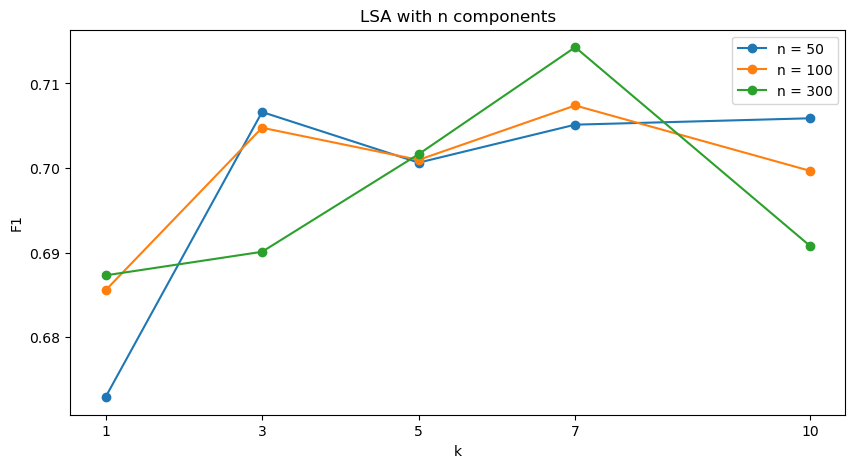

In [29]:
# plot the results
import matplotlib.pyplot as plt

ks_50 = list(results[50].keys())
ks_100 = list(results[100].keys())
ks_300 = list(results[300].keys())

f1s_50 = [results[50][k]['f1'] for k in ks]
f1s_100 = [results[100][k]['f1'] for k in ks]
f1s_300 = [results[300][k]['f1'] for k in ks]

plt.figure(figsize=(10, 5))
plt.plot(ks_50, f1s_50, marker='o', label='n = 50')
plt.plot(ks_100, f1s_100, marker='o', label='n = 100')
plt.plot(ks_300, f1s_300, marker='o', label='n = 300')
plt.xticks(ks)
plt.title('LSA with n components')
plt.xlabel('k')
plt.ylabel('F1')
plt.legend()
plt.show()

### Representing reviews with GloVe embeddings

Now, let's do the exact same thing, but use pre-trained embeddings. We'll use 100-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings, but feel free to explore independently using embeddings from other sources.

How do you think our LSA vectors of the same size (n=100) will compare to GloVe? What about our larger (n=300) LSA vectors?

In [30]:
# Get pre-trained embeddings
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load("glove-wiki-gigaword-100")

In [31]:
word_vectors['grill'] # just taking a peek

array([-0.35266  , -0.28192  , -0.59465  , -0.02931  , -0.55774  ,
       -0.070758 ,  0.40597  ,  0.70396  ,  0.14796  ,  0.10115  ,
        0.31426  , -0.036878 , -0.019801 ,  0.087431 , -0.51147  ,
       -0.28561  ,  0.037625 , -0.65615  , -0.5924   , -0.68787  ,
        0.098768 , -0.32503  ,  0.047738 , -1.1288   ,  0.86624  ,
        0.89262  , -0.020804 , -0.042391 , -1.0561   , -0.45359  ,
       -0.47901  ,  0.90461  ,  0.41834  ,  0.46145  , -0.11528  ,
        0.84465  ,  0.14283  , -0.51629  ,  0.79099  , -0.56084  ,
        0.59581  , -0.75944  , -0.47828  , -1.0561   , -0.16451  ,
       -0.24906  , -1.1196   , -0.20763  ,  0.54617  , -0.27398  ,
       -0.2001   , -0.3316   , -0.75993  ,  0.70688  , -0.9803   ,
       -0.83881  ,  0.25246  ,  0.16616  ,  0.36306  , -0.10676  ,
       -0.10932  ,  1.1076   ,  0.67402  ,  0.28467  ,  1.0918   ,
       -0.54278  ,  0.52442  ,  0.33522  , -0.7778   , -0.52074  ,
       -0.70794  ,  0.18827  ,  1.2152   ,  0.60066  , -0.4302

In [32]:
# Let's put the glove embeddings into a pd.DataFrame for compatibility with our previous functions
glove_matrix = pd.DataFrame({word: word_vectors[word] for word in word_vectors.key_to_index.keys()}).T

In [33]:
glove_matrix.loc['grill'] # The 'grill' term vector in the GloVe matrix - looks like our LSA embeddings now

0    -0.352660
1    -0.281920
2    -0.594650
3    -0.029310
4    -0.557740
        ...   
95   -0.238820
96    0.347880
97   -0.065795
98    1.649600
99    0.132920
Name: grill, Length: 100, dtype: float32

In [34]:
# Let's redo our experiments with GloVe embeddings
data_and_annotations['train']['pos']['glove'] = []
data_and_annotations['train']['neg']['glove'] = []
data_and_annotations['test']['glove'] = []
with open('positive_reviews_train.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        review = row[1]
        glove_review_vector = review2vec(review, glove_matrix)
        data_and_annotations['train']['pos']['glove'].append(glove_review_vector)
with open('negative_reviews_train.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        review = row[1]
        glove_review_vector = review2vec(review, glove_matrix)
        data_and_annotations['train']['neg']['glove'].append(glove_review_vector)
with open('test.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, row in enumerate(reader):
        review = row[1]
        glove_review_vector = review2vec(review, glove_matrix)
        data_and_annotations['test']['glove'].append(glove_review_vector)

In [35]:
# Let's define experimental conditions
ks = [1, 3, 5, 7, 10]
results['glove-100'] = {}

print('Running experiments for GloVe embeddings...')
test_ids = np.array(data_and_annotations['test']['ids'])
test_sentiment = np.array(data_and_annotations['test']['sentiment'])

test_review_vectors = np.array(deepcopy(data_and_annotations['test']['glove']))
positive_review_vectors = np.array(deepcopy(data_and_annotations['train']['pos']['glove']))
negative_review_vectors = np.array(deepcopy(data_and_annotations['train']['neg']['glove']))

for k in ks:
    print('Running experiments for k = {}...'.format(k))
    results['glove-100'][k] = {}
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for t_i, t_v, t_s in zip(test_ids, test_review_vectors, test_sentiment):
        predicted_sentiment = classify_sentiment(t_v, positive_review_vectors, negative_review_vectors, k)
        if predicted_sentiment == 'pos':
            if t_s == 'pos':
                tp += 1
            else:
                fp += 1
        else:
            if t_s == 'neg':
                tn += 1
            else:
                fn += 1

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0

    results['glove-100'][k]['accuracy'] = accuracy
    results['glove-100'][k]['precision'] = precision
    results['glove-100'][k]['recall'] = recall
    results['glove-100'][k]['f1'] = f1
print('Done!')

Running experiments for GloVe embeddings...
Running experiments for k = 1...
Running experiments for k = 3...
Running experiments for k = 5...
Running experiments for k = 7...
Running experiments for k = 10...
Done!


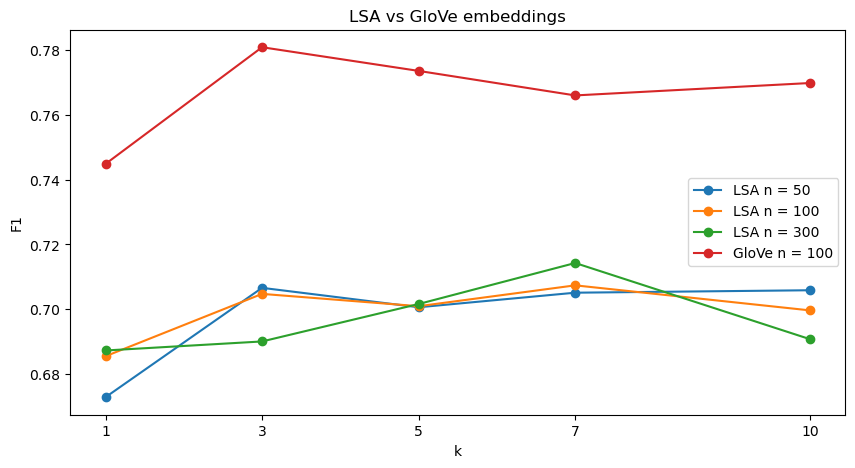

In [36]:
# plot the results, along with the LSA results
ks_glove = list(results['glove-100'].keys())
f1s_glove = [results['glove-100'][k]['f1'] for k in ks]

plt.figure(figsize=(10, 5))
plt.plot(ks_50, f1s_50, marker='o', label='LSA n = 50')
plt.plot(ks_100, f1s_100, marker='o', label='LSA n = 100')
plt.plot(ks_300, f1s_300, marker='o', label='LSA n = 300')
plt.plot(ks_glove, f1s_glove, marker='o', label='GloVe n = 100')
plt.xticks(ks)
plt.title('LSA vs GloVe embeddings')
plt.xlabel('k')
plt.ylabel('F1')
plt.legend()
plt.show()

## Conclusion

Looks like our LSA embeddings couldn't keep up with the pre-trained GloVe embeddings. To close out the homework, take some time to reflect and maybe speculate on why that would be: is it the way GloVe was trained? Or maybe it's the data GloVe was trained on?